# Import

In [2]:
%matplotlib inline

import math
from pathlib import Path
from functools import partial
from inspect import isfunction

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

# Define Networks

In [3]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, classes_emb_dim = None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(int(time_emb_dim) + int(classes_emb_dim), dim_out * 2))
            if exists(time_emb_dim) or exists(classes_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None, class_emb=None):
        scale_shift = None
        if exists(self.mlp) and(exists(time_emb) or exists(class_emb)):
            cond_emb = tuple(filter(exists, (time_emb, class_emb)))
            cond_emb = torch.cat(cond_emb, dim = -1)
            cond_emb = self.mlp(cond_emb)
            cond_emb = rearrange(cond_emb, 'b c -> b c 1 1')
            scale_shift = cond_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
    
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        num_classes,
        cond_drop_prob=0.5,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()
        
        self.cond_drop_prob = cond_drop_prob

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )
        
        # class embeddings
        self.classes_emb = nn.Embedding(num_classes, dim)
        self.null_classes_emb = nn.Parameter(torch.randn(dim))

        classes_dim = dim * 4

        self.classes_mlp = nn.Sequential(
            nn.Linear(dim, classes_dim),
            nn.GELU(),
            nn.Linear(classes_dim, classes_dim)
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim, classes_emb_dim=classes_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim, classes_emb_dim=classes_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )#ok

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, classes_emb_dim=classes_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, classes_emb_dim=classes_dim)
        #ok
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim, classes_emb_dim=classes_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim, classes_emb_dim=classes_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )#ok

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim, classes_emb_dim=classes_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)
        
    def forward_with_cond_scale(self, *args, cond_scale=1., rescaled_phi=0., **kwargs):
        logits = self.forward(*args, cond_drop_prob = 0., **kwargs)

        if cond_scale == 1:
            return logits

        null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)
        scaled_logits = null_logits + (logits - null_logits) * cond_scale

        if rescaled_phi == 0.:
            return scaled_logits

        std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
        rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))

        return rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

    def forward(self, x, time, classes, cond_drop_prob=None):
        batch, device = x.shape[0], x.device

        cond_drop_prob = default(cond_drop_prob, self.cond_drop_prob)#ok

        classes_emb = self.classes_emb(classes)
        if cond_drop_prob > 0:
            keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)
            null_classes_emb = repeat(self.null_classes_emb, 'd -> b d', b = batch)

            classes_emb = torch.where(
                rearrange(keep_mask, 'b -> b 1'),
                classes_emb,
                null_classes_emb
            )

        c = self.classes_mlp(classes_emb)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, c)
            h.append(x)

            x = block2(x, t, c)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, c)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, c)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t, c)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t, c)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t, c)
        return self.final_conv(x)

# Define the forward process


In [4]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# 各時刻に対応する値を返す
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [5]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# Loss function

In [6]:
def p_losses(denoise_model, x_start, t, classes, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, classes)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Create DataLoader

In [7]:
batch_size = 128

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# create dataloader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 56084185.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46447735.36it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19547625.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8370179.60it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Define the reverse process

In [8]:
@torch.no_grad()
def p_sample(model, x, classes, t, t_index, cond_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, cond_scale=cond_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_scale=6., rescaled_phi=0.7):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, classes, torch.full((b,), i, device=device, dtype=torch.long), i, cond_scale=cond_scale, rescaled_phi=rescaled_phi)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, classes, image_size, batch_size=16, channels=3, cond_scale=6., rescaled_phi=0.7):
    return p_sample_loop(model, classes, shape=(batch_size, channels, image_size, image_size), cond_scale=cond_scale, rescaled_phi=rescaled_phi)


# Train

In [11]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000
epochs = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = 28
channels = 1
model_path = './classifier_free_guidance.pth'

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    num_classes=10,
    cond_drop_prob=0.5,
)
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# # start training
# for epoch in range(epochs):
#     for step, (batch, classes) in enumerate(dataloader):
#         optimizer.zero_grad()

#         batch = batch.to(device)
#         classes = classes.to(device)

#         # Algorithm 1 line 3: sample t uniformally for every example in the batch
#         t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()

#         loss = p_losses(model, batch, t, classes, loss_type="huber")

#         if step % 100 == 0:
#             print("Loss:", loss.item())

#         loss.backward()
#         optimizer.step()

#         # save generated images
#         if step != 0 and step % save_and_sample_every == 0:
#             milestone = step // save_and_sample_every
#             batches = num_to_groups(4, batch_size)
#             all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
#             all_images = torch.cat(all_images_list, dim=0)
#             all_images = (all_images + 1) * 0.5
#             save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

# torch.save(model.state_dict(), model_path)


# Load trained model

In [12]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    num_classes=10,
    cond_drop_prob=0.5,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (classes_emb): Embedding(10, 28)
  (classes_mlp): Sequential(
    (0): Linear(in_features=28, out_features=112, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=224, out_features=56, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardi

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

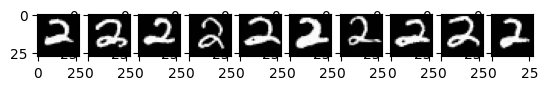

In [11]:
# 同じノイズからどんな画像が生成されるか
# image = dataloader.dataset[0][0].unsqueeze(0)
noise = torch.randn_like(torch.zeros((1, 1, 28, 28)))
noise_img = torch.cat([noise for _ in range(10)], dim=0)
# noise_img = q_sample(image, torch.tensor([300-1]), noise=noise)

fig, ax = plt.subplots(1, 10)
with torch.no_grad():
    shape = noise_img.shape
    b = shape[0]
    classes = torch.full((b,), 2, device=device, dtype=torch.long)
    img = noise_img
    img = img.to(device)

    for i in tqdm(reversed(range(0, 300)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, classes, torch.full((b,), i, device=device, dtype=torch.long), i)

    for num in range(10):
        ax[num].imshow(img[num].cpu().detach().clone().reshape(image_size, image_size, channels), cmap='gray')


# Inference

## 各クラスうまくできるか

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

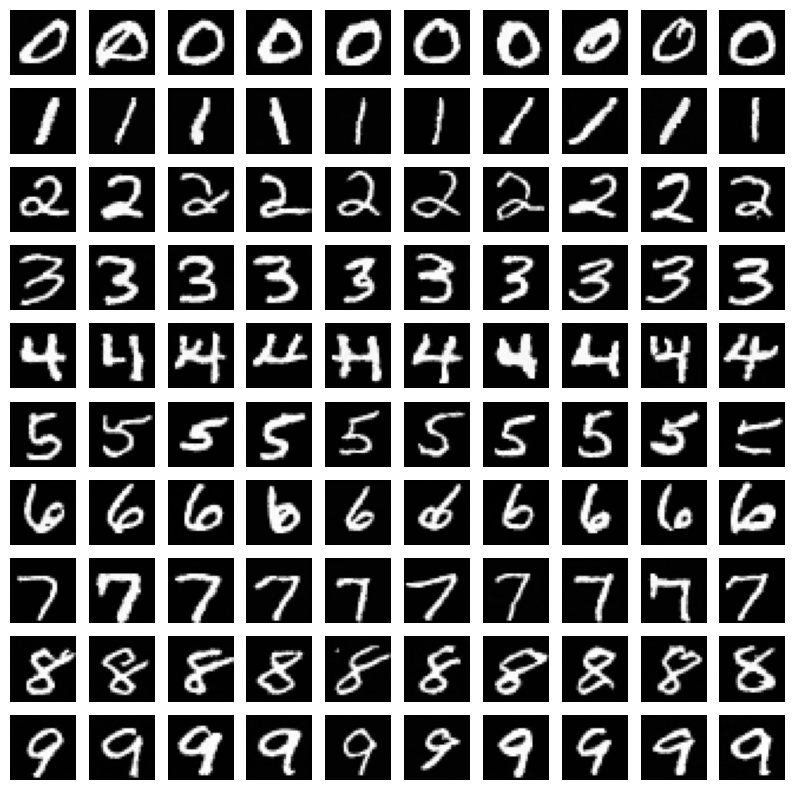

In [38]:
samples_list = []
for c in range(10):
    b = 10
    classes = torch.full((b,), c, device=device, dtype=torch.long)
    # sample 10 images
    samples = sample(model, classes, image_size=image_size, batch_size=b, channels=channels, cond_scale=6., rescaled_phi=0.7)
    samples_list.append(samples)

# show images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    x = i // 10
    y = i % 10
    ax[x, y].axis("off")
    ax[x, y].imshow(samples_list[x][-1][y].reshape(image_size, image_size, channels), cmap="gray")

## classes=Noneのときの生成画像

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

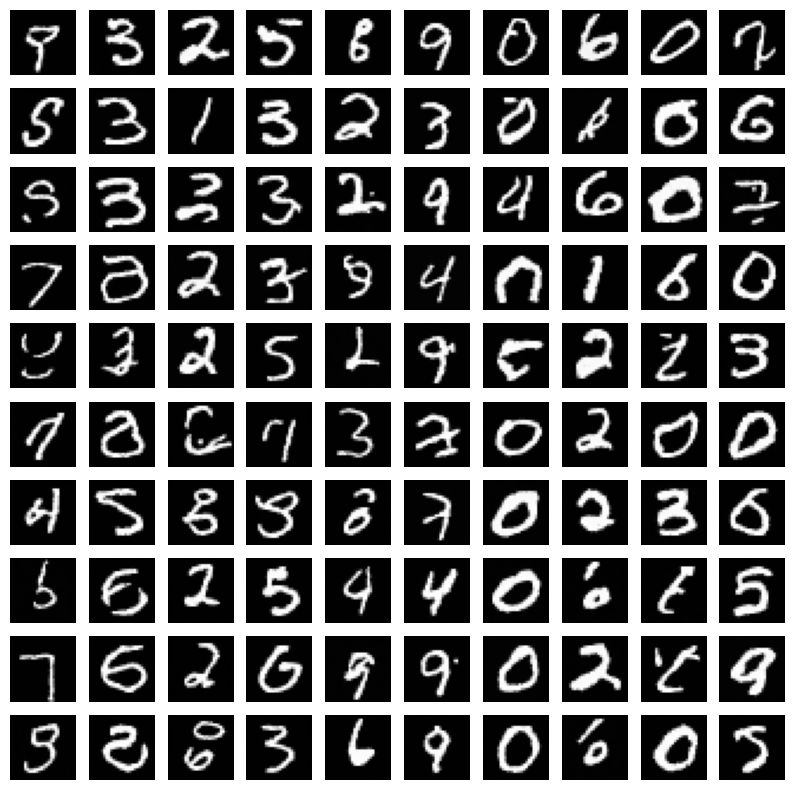

In [32]:
# classes=noneにしたときの挙動
@torch.no_grad()
def none_p_sample(model, x, classes, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model(x, t, classes, cond_drop_prob=1)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


imgs = []
shape = (10, 1, 28, 28)
device = next(model.parameters()).device
b = shape[0]
noise = torch.randn(shape, device=device)
for c in range(10):
    img = noise
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = none_p_sample(model, img, torch.full((b,), 0, device=device, dtype=torch.long), torch.full((b,), i, device=device, dtype=torch.long), i)
    imgs.append(img.cpu().numpy())

# show images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    x = i // 10
    y = i % 10
    ax[x, y].axis("off")
    ax[x, y].imshow(imgs[x][y].reshape(image_size, image_size, channels), cmap="gray")

## 各クラス方向のノイズの可視化

In [13]:
# 同じノイズからの各クラスのノイズの方向
noise_img = torch.randn_like(torch.zeros((1, 1, 28, 28)), device=device)
noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]
t_range = (290, timesteps) 

noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for i in range(10)]
for c in range(10):
    classes = torch.full((b,), c, device=device, dtype=torch.long)
    x = noise_img 
    with torch.no_grad():
        for i in tqdm(reversed(range(t_range[0], t_range[1])), desc='sampling loop time step', total=timesteps):
            # img = none_p_sample(model, img, torch.full((b,), 0, device=device, dtype=torch.long), torch.full((b,), i, device=device, dtype=torch.long), i)

            t = torch.full((b,), i, device=device, dtype=torch.long)
            
            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            pred_noise = model.forward_with_cond_scale(x, t, classes, cond_scale=6., rescaled_phi=0.7)
            noise_ave_list[c] += pred_noise.cpu().detach().clone()
            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if i == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                noise = torch.randn_like(x)
                # Algorithm 2 line 4:
                x = model_mean + torch.sqrt(posterior_variance_t) * noise 

        noise_ave_list[c] = noise_ave_list[c] / timesteps
    
    # fig, ax = plt.subplots(1, 10)
    # for i in range(10):
    #     ax[i].axis("off")
    #     ax[i].imshow(x[i].cpu().detach().reshape(image_size, image_size, channels), cmap="gray")
    # plt.show()

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

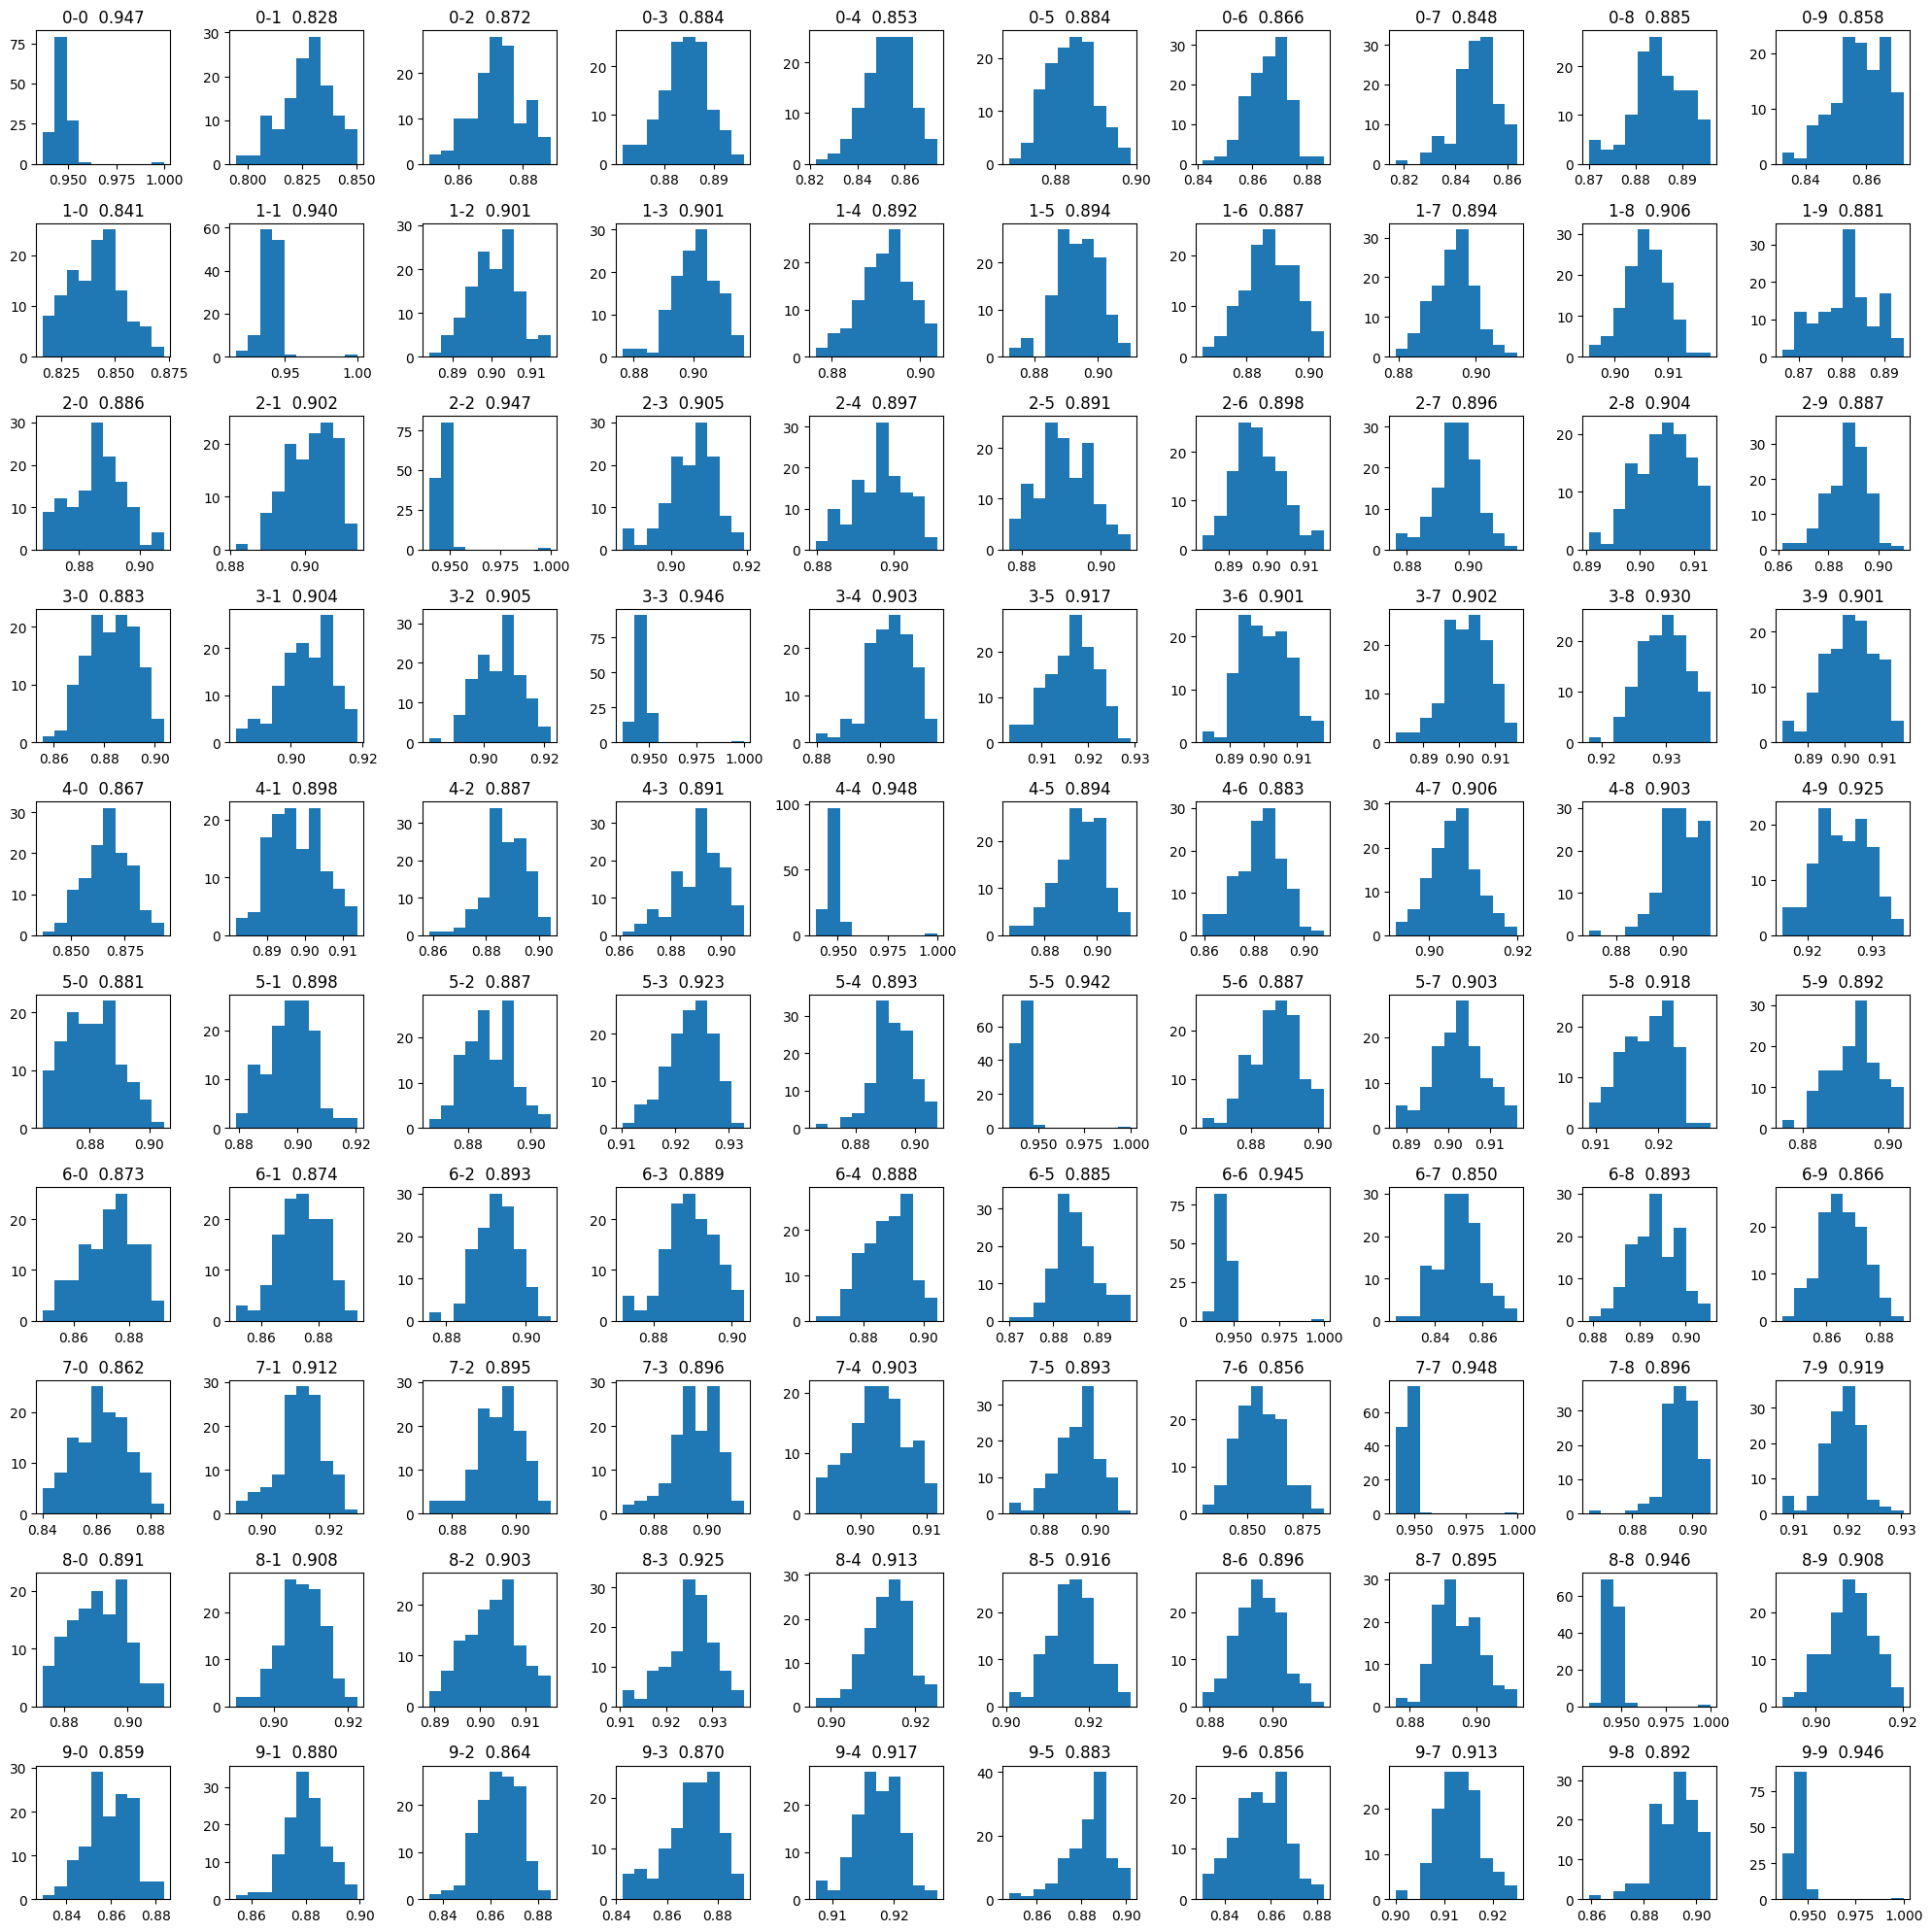

In [16]:
# torch.nn.functional.cosine_similarity(noise_ave_list[0][0].reshape(-1), noise_ave_list[1].reshape(b, -1))
cos_sim_list = [[] for _ in range(10)]
for source_i in range(10):
    for target_i in range(10):
        cos_sim_list[source_i].append(torch.nn.functional.cosine_similarity(noise_ave_list[source_i][0].reshape(-1), noise_ave_list[target_i].reshape(b, -1)))


fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        ax[i, j].set_title(f"{i}-{j}  {cos_sim_list[i][j].mean():.3f}")
        ax[i, j].hist(cos_sim_list[i][j].cpu().detach().numpy())
        
plt.tight_layout()
plt.savefig(f'./cos_sim_time{t_range[0]}-{t_range[1]}.png')
plt.show()

[0.14264312 0.09576179 0.07559104]


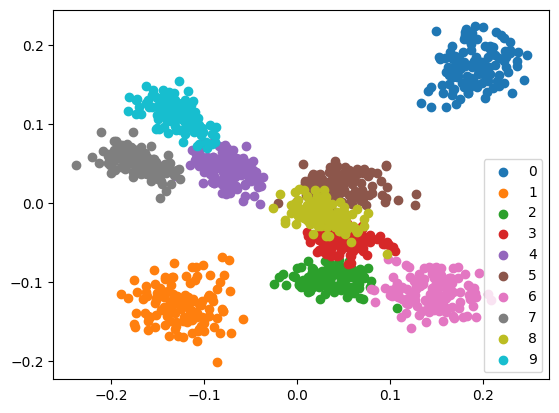

In [17]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*10, -1).numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

for i in range(0, len(X_reduced), b):
    plt.scatter(x[i:i+b], y[i:i+b], label=i//b)
plt.legend()
plt.savefig(f'./PCA_time{t_range[0]}-{t_range[1]}.png')
plt.show()


## ノイズの合成